<a href="https://colab.research.google.com/github/fabriciosantana/mcdia/blob/main/01-icd/assignments/03-analise-aprendizado-supervisionado" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise dos Discursos do Senado com Algoritmos de Aprendizado Supervisionado 

Este notebook aplica modelos de aprendizado supervisionado aos discursos profridos no Senado. Para isso, o corpus de discursos é analisado sob diferentes classificadores lineares baseados em TF-IDF para prever o partido responsável por cada fala.


## Importar bibliotecas

Importar bibliotecas para manipulação dos discursos, visualização, acesso ao repositório de dados e construção dos pipelines com algoritmos de aprendizado supervisionado.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from datasets import load_dataset_builder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Carregar dados

Carregar o conjunto de discursos diretamente do repositório `fabriciosantana/discursos-senado-legislatura-56` no Hugging Face, obtendo um `DataFrame` com os metadados e o texto integral de cada pronunciamento.


In [2]:
#DATA_PATH = Path('data/hf_discursos/data/full/discursos_2019-02-01_2023-01-31.parquet')
#df_raw = pd.read_parquet(DATA_PATH)

DATASET_HF_REPO = "fabriciosantana/discursos-senado-legislatura-56"
DATA_FILE_HF = {"train": "data/full/discursos_2019-02-01_2023-01-31.parquet"}

dataset = load_dataset(DATASET_HF_REPO, data_files=DATA_FILE_HF)
df_raw = dataset["train"].to_pandas()

df_raw.head()

,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,Apartes.Aparteante,__janela_inicio,__janela_fim,CargoAutor,OrgaoAutor,PaisAutor,TextoDiscursoIntegral,ok,status,msg
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,
3,451203,451203,Senado Federal,2019-02-27,Expectativa com o início dos trabalhos no âmbi...,"EXPECTATIVA, INICIO, TRABALHO, COMISSÕES, SENA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. CONFÚCIO MOURA (Bloco Parlamentar Unidos...,True,200,
4,451202,451202,Senado Federal,2019-02-27,Relato da origem e das motivações do Projeto d...,"COMENTARIO, ORIGEM, MOTIVO, PROJETO DE LEI, OB...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. RODRIGO PACHECO (Bloco Parlamentar Vangu...,True,200,


## Preparar dados para análise

Preparar base para para manter apenas colunas relevantes, remover valores ausentes, normalizar o texto e descartar discursos curtos, garantindo uma base limpa e informativa para os modelos.


In [3]:
colunas = ['Data', 'NomeAutor', 'Partido', 'UF', 'TextoDiscursoIntegral']
df = (

    df_raw[colunas]

    .rename(columns={

        'TextoDiscursoIntegral': 'texto',

        'NomeAutor': 'nome_autor'

    })

    .dropna(subset=['Partido', 'texto'])

)

df['texto'] = df['texto'].str.strip()
df = df[df['texto'].str.len() > 0]
df['n_palavras'] = df['texto'].str.split().str.len()
df = df[df['n_palavras'] >= 20]
df

,Data,nome_autor,Partido,UF,texto,n_palavras
0,2019-02-27,Ciro Nogueira,PP,PI,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,873
1,2019-02-27,Paulo Paim,PT,RS,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,1588
2,2019-02-27,Wellington Fagundes,PR,MT,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,4682
3,2019-02-27,Confúcio Moura,MDB,RO,O SR. CONFÚCIO MOURA (Bloco Parlamentar Unidos...,3515
4,2019-02-27,Rodrigo Pacheco,DEM,MG,O SR. RODRIGO PACHECO (Bloco Parlamentar Vangu...,5774
...,...,...,...,...,...,...
15723,2023-01-10,Davi Alcolumbre,UNIÃO,AP,O SR. DAVI ALCOLUMBRE (Bloco Parlamentar União...,1880
15724,2023-01-10,Lael Varella,DEM,MG,O SR. LAEL VARELLA (DEM - MG. Para discursar.)...,281
15726,2023-01-10,Rodrigo Pacheco,PSD,MG,O SR. PRESIDENTE (Rodrigo Pacheco. Bloco Parla...,145
15727,2023-01-10,Omar Aziz,PSD,AM,O SR. OMAR AZIZ (Bloco Parlamentar PSD/Republi...,969


## Discursos por partido

Com os dados limpos, contabilizar quantos pronunciamentos existem por partido para identificar quais legendas possuem volume suficiente e merecem análise supervisionada.


In [4]:
top_partidos = df['Partido'].value_counts().head(8)
top_partidos

Partido
PT         1662
MDB        1595
PODEMOS    1566
PSD        1288
PSDB       1140
PP          906
PL          810
DEM         722
Name: count, dtype: int64

## Selecionar partidos

A partir das contagens anteriores, selecionar os oito partidos mais frequentes e aplicar amostragem aleatória estratificada para equilibrar o número de discursos por sigla antes do treinamento.


In [5]:
partidos_selecionados = top_partidos.index.tolist()
df_modelo = df[df['Partido'].isin(partidos_selecionados)].copy()
max_por_partido = 800
df_balanceado = (
    df_modelo
        .groupby('Partido', group_keys=False)
        .apply(lambda grupo: grupo.sample(min(len(grupo), max_por_partido), random_state=42))
        .reset_index(drop=True)    
    )

df_balanceado['Partido'].value_counts()

/tmp/ipykernel_2933/84274680.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grupo: grupo.sample(min(len(grupo), max_por_partido), random_state=42))


Partido
MDB        800
PL         800
PODEMOS    800
PP         800
PSDB       800
PSD        800
PT         800
DEM        722
Name: count, dtype: int64

## Separar conjunto de treino e teste

Com o subconjunto balanceado, separar as amostras em conjuntos de treino e teste estratificados, preservando a proporção de partidos para avaliar os modelos de forma justa.


In [6]:
X = df_balanceado['texto']
y = df_balanceado['Partido']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
len(X_train), len(X_test)

(5057, 1265)

## Aplicar Regressão Logística com TF-IDF

Montar um pipeline que transforma os textos em vetores TF-IDF com n-gramas até bi-gramas e treinar uma regressão logística, registrando acurácia e relatório de classificação por partido.


In [7]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        min_df=5,
        strip_accents='unicode'
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        #multi_class='multinomial',
        solver='lbfgs',
        random_state=42
    ))
])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f'Acurácia (logística): {acc_lr:.3f}')
print(classification_report(y_test, y_pred_lr)) 

Acurácia (logística): 0.957
              precision    recall  f1-score   support

         DEM       0.93      0.99      0.96       145
         MDB       0.97      0.96      0.97       160
          PL       0.97      0.94      0.95       160
     PODEMOS       0.95      0.92      0.94       160
          PP       0.99      0.94      0.96       160
         PSD       0.90      0.98      0.94       160
        PSDB       0.97      0.94      0.96       160
          PT       0.97      0.99      0.98       160

    accuracy                           0.96      1265
   macro avg       0.96      0.96      0.96      1265
weighted avg       0.96      0.96      0.96      1265



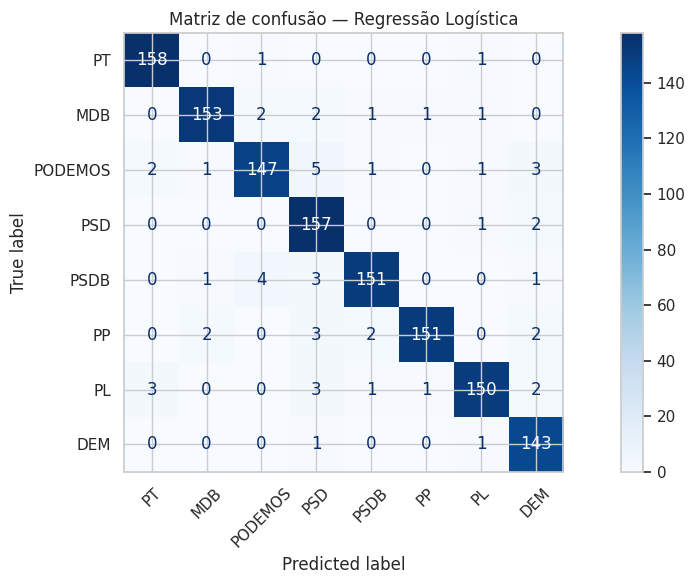

In [8]:
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=partidos_selecionados)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=partidos_selecionados)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matriz de confusão — Regressão Logística')
plt.tight_layout()

## Aplicar SVM Linear

Repetir o fluxo com uma `LinearSVC`, avaliando como um classificador de margem máxima se comporta com a mesma representação TF-IDF e registrando as métricas de desempenho.


In [9]:
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        min_df=5,
        strip_accents='unicode'
    )),
    ('clf', LinearSVC(random_state=42))
])
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f'Acurácia (SVM linear): {acc_svm:.3f}')
print(classification_report(y_test, y_pred_svm))

Acurácia (SVM linear): 0.973
              precision    recall  f1-score   support

         DEM       0.99      0.99      0.99       145
         MDB       0.98      0.97      0.97       160
          PL       0.98      0.97      0.97       160
     PODEMOS       0.97      0.94      0.96       160
          PP       0.97      0.97      0.97       160
         PSD       0.93      0.99      0.96       160
        PSDB       0.98      0.97      0.98       160
          PT       0.98      0.98      0.98       160

    accuracy                           0.97      1265
   macro avg       0.97      0.97      0.97      1265
weighted avg       0.97      0.97      0.97      1265



## Aplicar Multinomial Naive Bayes com TF-IDF

Modelo probabilístico que costuma funcionar bem em tarefas de categorização de texto por assumir distribuição multinomial sobre as contagens de termos. Aqui ele recebe as características de TF-IDF, é ajustado aos dados de treino e tem sua acurácia e relatório de classificação calculados para comparar com os demais algoritmos.


In [10]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        min_df=5,
        strip_accents='unicode'
    )),
    ('clf', MultinomialNB())
])

pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

print(f'Acurácia (Naive Bayes): {acc_nb:.3f}')
print(classification_report(y_test, y_pred_nb))


Acurácia (Naive Bayes): 0.882
              precision    recall  f1-score   support

         DEM       0.86      0.92      0.89       145
         MDB       0.92      0.89      0.91       160
          PL       0.92      0.86      0.89       160
     PODEMOS       0.86      0.89      0.87       160
          PP       0.90      0.88      0.89       160
         PSD       0.85      0.77      0.81       160
        PSDB       0.90      0.89      0.90       160
          PT       0.84      0.96      0.90       160

    accuracy                           0.88      1265
   macro avg       0.88      0.88      0.88      1265
weighted avg       0.88      0.88      0.88      1265



## Aplicar Passive Aggressive Classifier

Modelo linear on-line que se adapta rapidamente a novos dados e costuma lidar bem com classes desbalanceadas quando combinado com TF-IDF. No notebook treinamos o classificador com as mesmas features TF-IDF, medimos sua acurácia e extraímos o relatório de classificação para verificar a robustez em relação aos outros modelos lineares.


In [11]:
pipeline_pa = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        min_df=5,
        strip_accents='unicode'
    )),
    ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=42, tol=1e-3))
])

pipeline_pa.fit(X_train, y_train)
y_pred_pa = pipeline_pa.predict(X_test)
acc_pa = accuracy_score(y_test, y_pred_pa)

print(f'Acurácia (Passive Aggressive): {acc_pa:.3f}')
print(classification_report(y_test, y_pred_pa))


Acurácia (Passive Aggressive): 0.972
              precision    recall  f1-score   support

         DEM       0.97      0.98      0.98       145
         MDB       0.99      0.96      0.97       160
          PL       0.97      0.97      0.97       160
     PODEMOS       0.98      0.94      0.96       160
          PP       0.98      0.97      0.97       160
         PSD       0.93      0.99      0.96       160
        PSDB       0.98      0.99      0.98       160
          PT       0.98      0.98      0.98       160

    accuracy                           0.97      1265
   macro avg       0.97      0.97      0.97      1265
weighted avg       0.97      0.97      0.97      1265



## Comparar desempenho

Consolidar as acurácias obtidas por cada algoritmo em um `DataFrame`, ordenando os resultados para facilitar a interpretação de qual abordagem se destacou.


In [12]:
pd.DataFrame({
    'modelo': ['Regressão Logística', 'SVM Linear', 'Naive Bayes', 'Passive Aggressive'],
    'acuracia': [acc_lr, acc_svm, acc_nb, acc_pa]
}).sort_values('acuracia', ascending=False).reset_index(drop=True)


,modelo,acuracia
0,SVM Linear,0.973123
1,Passive Aggressive,0.972332
2,Regressão Logística,0.956522
3,Naive Bayes,0.882213


Os resultados indicam que modelos lineares com TF-IDF capturam bem o padrão de vocabulário associado a cada partido, tornando possível distinguir discursos com boa acurácia.

A análise também evidencia o impacto da preparação dos dados — filtragem, balanceamento e representação TF-IDF — na capacidade dos classificadores diferenciarem siglas com vocabulários semelhantes, sugerindo oportunidades para investigações futuras com modelos mais complexos.
